In [39]:
%autoreload 2
from plasmapy import simulation
import astropy.units as u
import numpy as np

In [40]:
import xarray

In [41]:
from plasmapy.classes.sources.interparticle import InterParticleForces

In [42]:
eq_distance = 0.1
forces = {key: InterParticleForces(key, 100, eq_distance, 1, 1e3, 0.01, 7) for key in ('python', 'njit', 'njit_parallel')}

from collections import namedtuple
CustomParticle = namedtuple('custom_particle', ['mass', 'charge'])
particle = CustomParticle(mass=1 * u.dimensionless_unscaled, charge=1 * u.dimensionless_unscaled)

L = 1 * u.m
N = 128
np.random.seed(0)
x = u.Quantity(np.random.random((N, 3))*L,  u.m)
v = u.Quantity(np.zeros(x.shape, dtype=float), u.m / u.s)

from scipy import spatial
tree = spatial.cKDTree(x)
close_pairs = tree.query_pairs(eq_distance)
while close_pairs:
    for a, b in close_pairs:
        x[b] = np.random.random(3) * L
    tree = spatial.cKDTree(x)
    close_pairs = tree.query_pairs(eq_distance)

In [43]:
%load_ext version_information
%version_information numba,numpy

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.7.6 64bit [GCC 7.3.0]
IPython 7.12.0
OS Linux 5.5.4 arch1 1 x86_64 with arch
numba 0.48.0
numpy 1.16.5
Sat Feb 22 07:23:04 2020 CET

In [44]:
solutions = {engine: simulation.ParticleTracker(forces[engine], x, v, particle).run(1e-1 * u.s, dt = 1e-6 * u.s) for engine in ['njit']}

# TODO there's a bug if n_snapshots > n_iterations

In [45]:
solution = solutions['njit']
solution

<xarray.Dataset>
Dimensions:           (dimension: 3, particle: 128, time: 1001)
Coordinates:
  * time              (time) float64 0.0 0.000101 0.000201 ... 0.0998 0.0999 0.1
  * particle          (particle) int64 0 1 2 3 4 5 6 ... 122 123 124 125 126 127
  * dimension         (dimension) <U1 'x' 'y' 'z'
Data variables:
    position          (time, particle, dimension) float64 0.5488 ... 0.3798
    velocity          (time, particle, dimension) float64 -0.001163 ... -6.893
    B                 (time, particle, dimension) float64 0.0 0.0 ... 0.0 0.0
    E                 (time, particle, dimension) float64 2.327e+03 ... 3.087e+04
    timestep          (time) float64 1e-06 1e-06 1e-06 ... 1e-06 1e-06 1e-06
    kinetic_energy    (time, particle) float64 7.749e-06 8.13e-05 ... 599.7
    potential_energy  (time, particle) float64 -223.3 -324.6 ... -43.2 -1.38e+03
Attributes:
    particle:          custom_particle(mass=<Quantity 1.>, charge=<Quantity 1.>)
    total_iterations:  100000

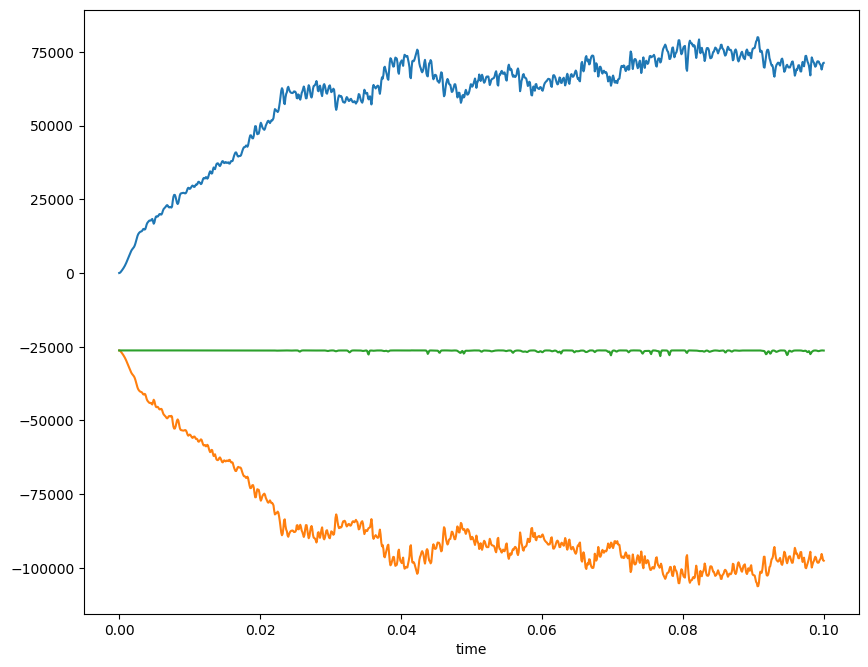

In [46]:
solution.kinetic_energy.sum(dim='particle').plot.line()
solution.potential_energy.sum(dim='particle').plot.line()
(solution.potential_energy + solution.kinetic_energy).sum(dim='particle').plot.line()

In [47]:
solution['position']

<xarray.DataArray 'position' (time: 1001, particle: 128, dimension: 3)>
array([[[0.5488135 , 0.71518937, 0.60276338],
        [0.54488318, 0.4236548 , 0.64589411],
        [0.43758721, 0.891773  , 0.96366276],
        ...,
        [0.16053882, 0.79639147, 0.9591666 ],
        [0.82076712, 0.90884372, 0.81552382],
        [0.92330607, 0.82989737, 0.96828641]],

       [[0.54882538, 0.71515233, 0.60275331],
        [0.54476187, 0.42366689, 0.64593589],
        [0.43758726, 0.89177262, 0.96366229],
        ...,
        [0.1605367 , 0.7963957 , 0.95916271],
        [0.82076422, 0.90883508, 0.81554818],
        [0.92326836, 0.82987425, 0.9682921 ]],

       [[0.54886057, 0.71504254, 0.60272348],
        [0.54441534, 0.42370288, 0.64605457],
        [0.43758742, 0.89177149, 0.96366088],
        ...,
        [0.1605304 , 0.79640819, 0.95915117],
        [0.82075563, 0.90880949, 0.81562042],
        [0.92315658, 0.82980618, 0.96830883]],

       ...,

       [[0.15407718, 0.73580325, 0.0836069 ],
        [0.75580624, 0.3538333 , 0.95482156],
        [0.0831299 , 0.05069622, 0.68125836],
        ...,
        [0.31303722, 0.96975346, 0.99830359],
        [0.94516555, 0.90537999, 0.38339903],
        [0.56594986, 0.77713845, 0.38124173]],

       [[0.15321582, 0.73495838, 0.0854525 ],
        [0.75248145, 0.35385107, 0.95464093],
        [0.08417639, 0.04829828, 0.67908748],
        ...,
        [0.31229869, 0.96779274, 0.9998332 ],
        [0.94022614, 0.90933357, 0.38185066],
        [0.56394585, 0.7737772 , 0.38053058]],

       [[0.15245267, 0.73412925, 0.08731095],
        [0.74915549, 0.35386731, 0.9544575 ],
        [0.08522428, 0.04590124, 0.67691563],
        ...,
        [0.31156012, 0.96583081, 1.00136154],
        [0.93527442, 0.91327386, 0.38029381],
        [0.56205316, 0.77066141, 0.37976979]]])
Coordinates:
  * time       (time) float64 0.0 0.000101 0.000201 0.0003 ... 0.0998 0.0999 0.1
  * particle   (particle) int64 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
  * dimension  (dimension) <U1 'x' 'y' 'z'
Attributes:
    unit:     m

In [59]:
N_bins = 10
N_times = 1000
for solution in solutions.values():
    # http://www.physics.emory.edu/faculty/weeks/idl/gofr2.html
    density = N / L ** 3

    from scipy import spatial

    import tqdm.auto as tqdm

    all_histograms = []
    max_L = L / 4
    bins, dx = np.linspace(0, max_L, N_bins, endpoint=True, retstep=True)
    our_times = solution.time[np.linspace(0, solution.time.size, N_times, endpoint=False, dtype=int)]
    spatial_bins = (bins[1:] + bins[:-1] )/2
    for time in tqdm.tqdm(our_times):
        pos = solution.position.sel(time=time)
        tree = spatial.cKDTree(pos)

        histograms = []
        for particle in range(N):
            distances, indices = tree.query(pos.sel(particle=particle), range(2, N))
            hist, final_bins = np.histogram(distances, bins)
            rdf = hist / (N * 4 * np.pi * spatial_bins **2 *  dx * density)
            histograms.append(rdf)
        all_histograms.append(histograms)


    
    da = xarray.DataArray(all_histograms,
                          dims=('time', 'particle', 'spatial_bins'),
                          coords = {'time': our_times, 'spatial_bins': spatial_bins, 'particle': solution.particle})
#     solution.coords['spatial_bins'] = spatial_bins

#     solution['rdf'] = (('time', 'particle', 'spatial_bins'), np.array(all_histograms))

#     solution.rdf.mean(dim='particle').isel(time=-3).plot.line()


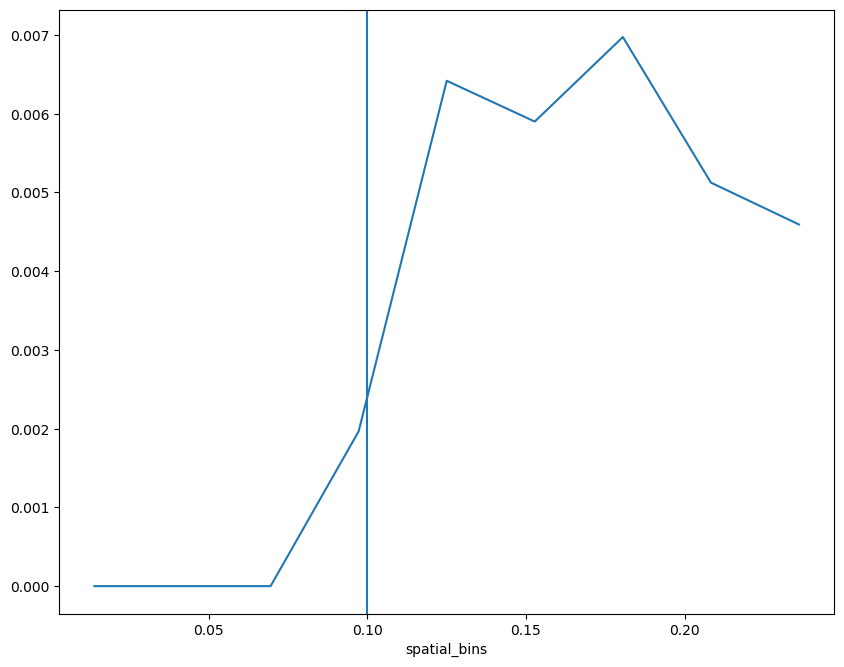

In [60]:
import matplotlib.pyplot as plt

da.isel(time=range(0, 1000)).mean(dim=['particle', 'time']).plot.line()
plt.axvline(eq_distance)

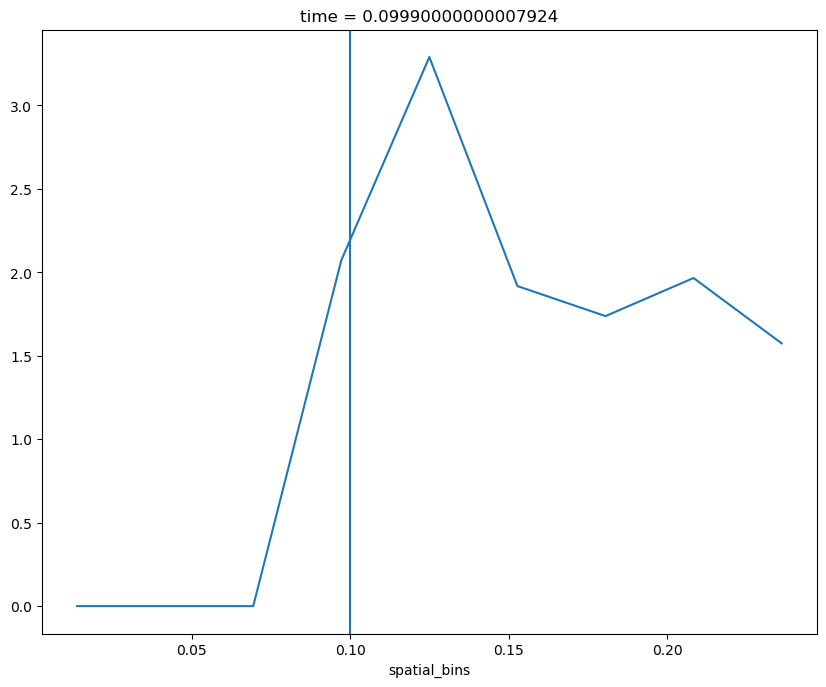

In [62]:
da.isel(time=-1).sum(dim='particle').plot.line()
plt.axvline(eq_distance)

In [67]:
pos = solution.position.isel(time=-1)
pos

interior_indices = np.prod([(rMax < pos.sel(dimension=dimension) ) & (pos.sel(dimension=dimension) < (domain_size - rMax)) for dimension in pos.dimension], axis=pos.get_axis_num('particle'))
interior_indices

filtered_pos = pos.sel(particle=list(*np.where(interior_indices)))
filtered_pos

In [98]:
if filtered_pos.sizes['particle'] == 0:
    raise RuntimeError("Filtering out particles in the wall regions filtered out everything. Decrease rMax or increase your cube size.")

In [97]:
number_density = filtered_pos.sizes['particle'] / L**3
number_density

<Quantity 53. 1 / m3>

<xarray.DataArray 'time' (time: 1)>
array([0.1])
Coordinates:
  * time     (time) float64 0.1
Attributes:
    unit:     s

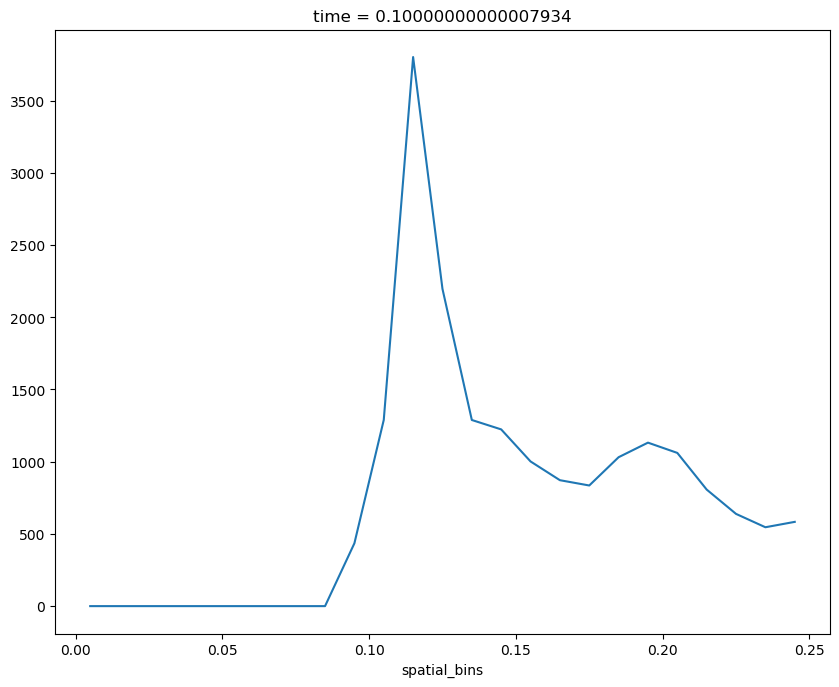

In [126]:
dr = 0.01
N_times = 10
for solution in solutions.values():
    # http://www.physics.emory.edu/faculty/weeks/idl/gofr2.html
    density = N / L ** 3

    from scipy import spatial

    import tqdm.auto as tqdm

    all_histograms = []
    max_L = L.si.value / 4
#     bins, dx = np.linspace(0, max_L, N_bins, endpoint=True, retstep=True)
    bins = np.arange(0, max_L+dr/2, dr)
    dx = dr 
#     our_times = solution.time[np.linspace(0, solution.time.size, N_times, endpoint=False, dtype=int)]
#     our_times = [solution.time.isel[-1]]
    spatial_bins = (bins[1:] + bins[:-1] )/2
    our_times = solution.time.isel(time=[-1])
    for time in tqdm.tqdm(our_times):
        pos = solution.position.sel(time=time)

        interior_indices = np.prod([(rMax < pos.sel(dimension=dimension) ) & (pos.sel(dimension=dimension) < (domain_size - rMax)) for dimension in pos.dimension], axis=pos.get_axis_num('particle'))

        filtered_pos = pos.sel(particle=list(*np.where(interior_indices)))
        if filtered_pos.sizes['particle'] == 0:
            raise RuntimeError("Filtering out particles in the wall regions filtered out everything. Decrease rMax or increase your cube size.")
        
        Np = filtered_pos.sizes['particle']
        number_density = filtered_pos.sizes['particle'] / L**3
        tree = spatial.cKDTree(filtered_pos)

        histograms = []
        for particle in range(Np):
            distances, indices = tree.query(pos.sel(particle=particle), range(2, Np))
            hist, final_bins = np.histogram(distances, bins)
            rdf = hist / (4/3 * np.pi * spatial_bins **3 *  dx * density)
            histograms.append(rdf)
        all_histograms.append(histograms)


    
    da = xarray.DataArray(all_histograms,
                          dims=('time', 'particle', 'spatial_bins'),
                          coords = {'time': our_times, 'spatial_bins': spatial_bins, 'particle': filtered_pos.particle})
#     solution.coords['spatial_bins'] = spatial_bins

#     solution['rdf'] = (('time', 'particle', 'spatial_bins'), np.array(all_histograms))

#     solution.rdf.mean(dim='particle').isel(time=-3).plot.line()

da.isel(time=-1).sum(dim='particle').plot()

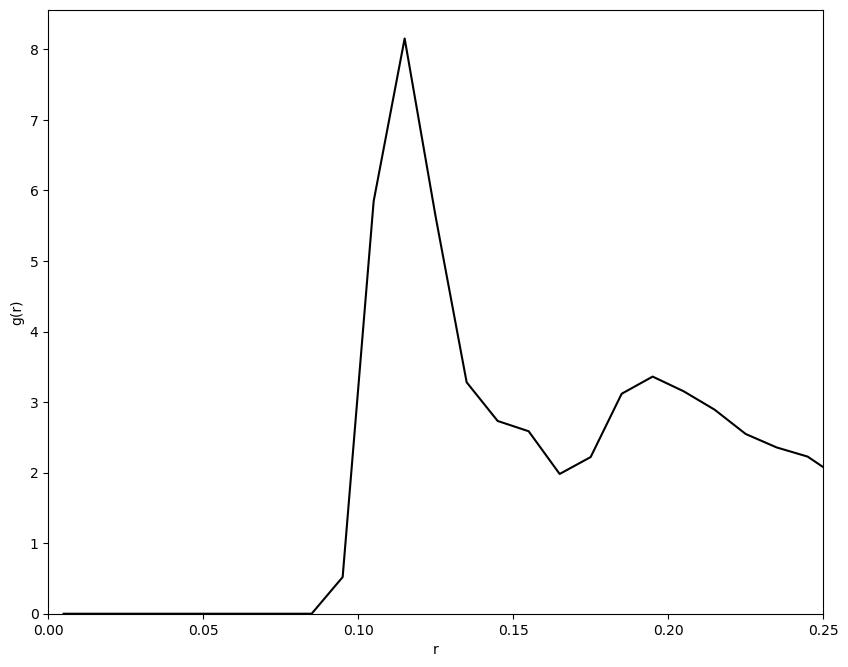

In [123]:
def pairCorrelationFunction_3D(x, y, z, S, rMax, dr):
    """Compute the three-dimensional pair correlation function for a set of
    spherical particles contained in a cube with side length S.  This simple
    function finds reference particles such that a sphere of radius rMax drawn
    around the particle will fit entirely within the cube, eliminating the need
    to compensate for edge effects.  If no such particles exist, an error is
    returned.  Try a smaller rMax...or write some code to handle edge effects! ;)
    Arguments:
        x               an array of x positions of centers of particles
        y               an array of y positions of centers of particles
        z               an array of z positions of centers of particles
        S               length of each side of the cube in space
        rMax            outer diameter of largest spherical shell
        dr              increment for increasing radius of spherical shell
    Returns a tuple: (g, radii, interior_indices)
        g(r)            a numpy array containing the correlation function g(r)
        radii           a numpy array containing the radii of the
                        spherical shells used to compute g(r)
        reference_indices   indices of reference particles
        
    # https://github.com/cfinch/Shocksolution_Examples/blob/master/PairCorrelation/paircorrelation.py
    """
    from numpy import zeros, sqrt, where, pi, mean, arange, histogram

    # Find particles which are close enough to the cube center that a sphere of radius
    # rMax will not cross any face of the cube
    bools1 = x > rMax
    bools2 = x < (S - rMax)
    bools3 = y > rMax
    bools4 = y < (S - rMax)
    bools5 = z > rMax
    bools6 = z < (S - rMax)

    interior_indices, = where(bools1 * bools2 * bools3 * bools4 * bools5 * bools6)
    num_interior_particles = len(interior_indices)

    if num_interior_particles < 1:
        raise  RuntimeError ("No particles found for which a sphere of radius rMax\
                will lie entirely within a cube of side length S.  Decrease rMax\
                or increase the size of the cube.")

    edges = arange(0., rMax + 1.1 * dr, dr)
    num_increments = len(edges) - 1
    g = zeros([num_interior_particles, num_increments])
    radii = zeros(num_increments)
    numberDensity = len(x) / S**3

    # Compute pairwise correlation for each interior particle
    for p in range(num_interior_particles):
        index = interior_indices[p]
        d = sqrt((x[index] - x)**2 + (y[index] - y)**2 + (z[index] - z)**2)
        d[index] = 2 * rMax

        (result, bins) = histogram(d, bins=edges, density=False)
        g[p,:] = result / numberDensity

    # Average g(r) for all interior particles and compute radii
    g_average = zeros(num_increments)
    for i in range(num_increments):
        radii[i] = (edges[i] + edges[i+1]) / 2.
        rOuter = edges[i + 1]
        rInner = edges[i]
        g_average[i] = mean(g[:, i]) / (4.0 / 3.0 * pi * (rOuter**3 - rInner**3))

    return (g_average, radii, interior_indices)
    # Number of particles in shell/total number of particles/volume of shell/number density
    # shell volume = 4/3*pi(r_outer**3-r_inner**3)
    
# # Particle setup
# domain_size = 20.0
# num_particles = 10000

# # Calculation setup
# dr = 0.1

# ### Random arrangement of particles ###
# rMax = domain_size / 4
# x = np.random.uniform(low=0, high=domain_size, size=num_particles)
# y = np.random.uniform(low=0, high=domain_size, size=num_particles)
# z = np.random.uniform(low=0, high=domain_size, size=num_particles)

# # Compute pair correlation
# g_r, r, reference_indices = pairCorrelationFunction_3D(x, y, z, domain_size, rMax, dr)

# # Visualize
# plt.figure()
# plt.plot(r, g_r, color='black')
# plt.xlabel('r')
# plt.ylabel('g(r)')
# plt.xlim( (0, rMax) )
# plt.ylim( (0, 1.05 * g_r.max()) )
# plt.show()

# Particle setup
domain_size = L.si.value
num_particles = N

# Calculation setup
dr = 0.01

### Random arrangement of particles ###
rMax = domain_size / 4
x = solution.position.isel(time=-1).sel(dimension='x').values
y = solution.position.isel(time=-1).sel(dimension='y').values
z = solution.position.isel(time=-1).sel(dimension='z').values

# Compute pair correlation
g_r, r, reference_indices = pairCorrelationFunction_3D(x, y, z, domain_size, rMax, dr)

# Visualize
plt.figure()
plt.plot(r, g_r, color='black')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.xlim( (0, rMax) )
plt.ylim( (0, 1.05 * g_r.max()) )
plt.show()

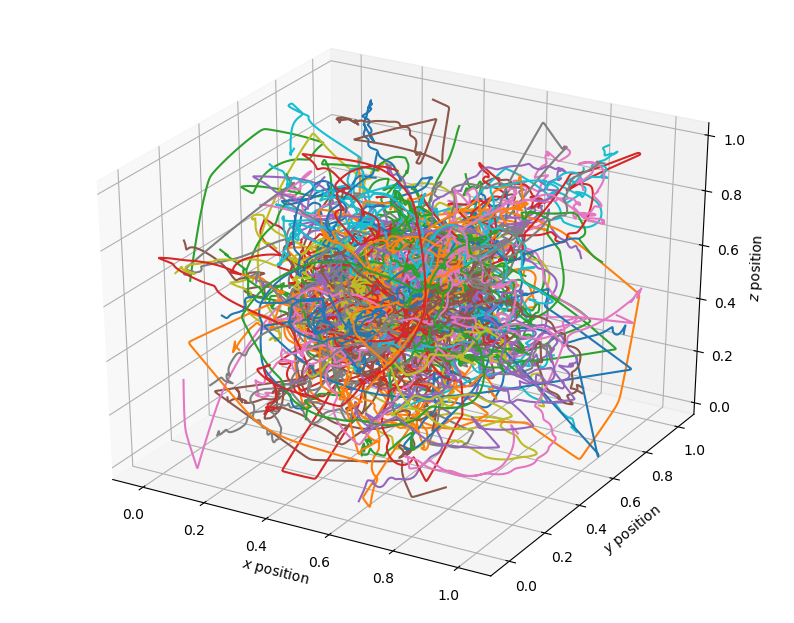

In [9]:
solution.particletracker.plot_trajectories()

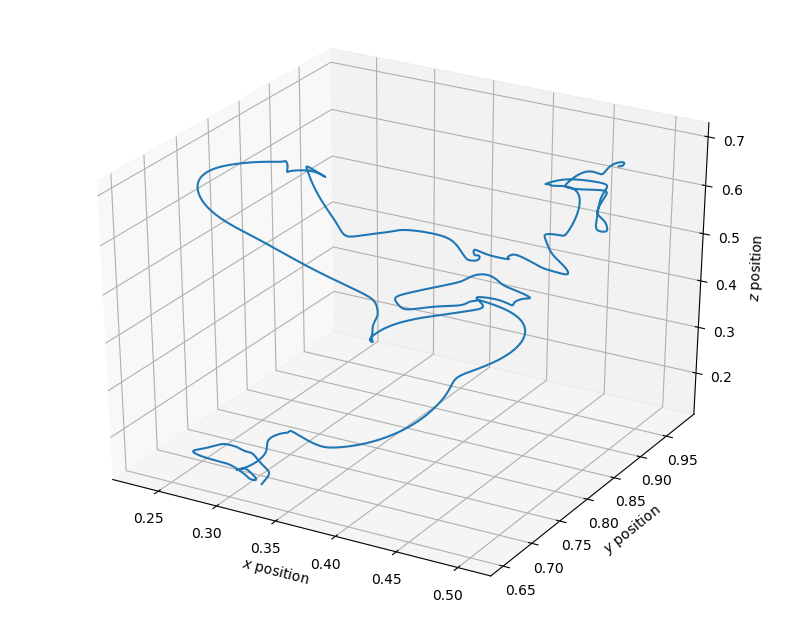

In [11]:
solution.sel(particle=[30]).particletracker.plot_trajectories()

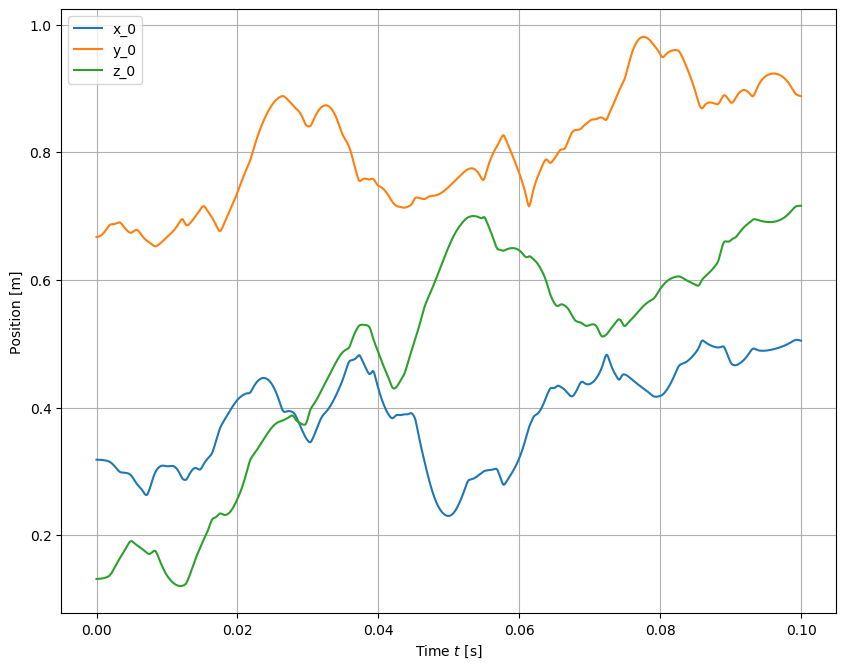

In [12]:
solution.sel(particle = [30]).particletracker.plot_time_trajectories()

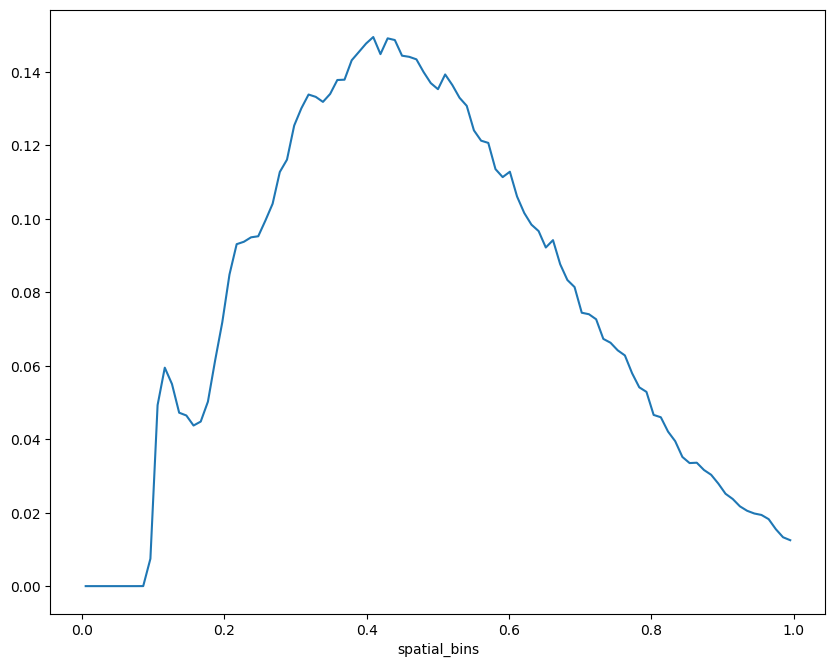

In [13]:
da.isel(time=range(900, 1000)).mean(dim=['particle', 'time']).plot.line()

In [14]:
np.array(all_histograms).shape

(1000, 128, 99)

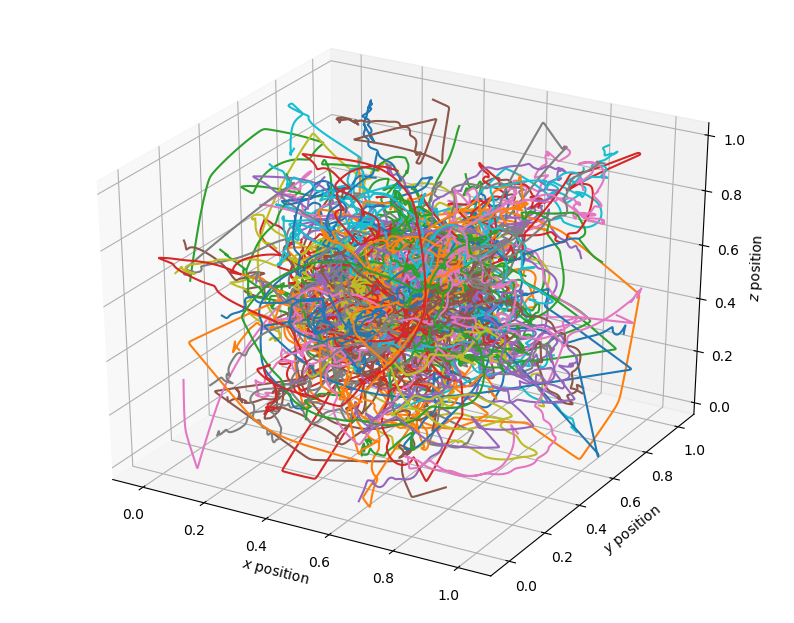

In [15]:
solution.particletracker.plot_trajectories()

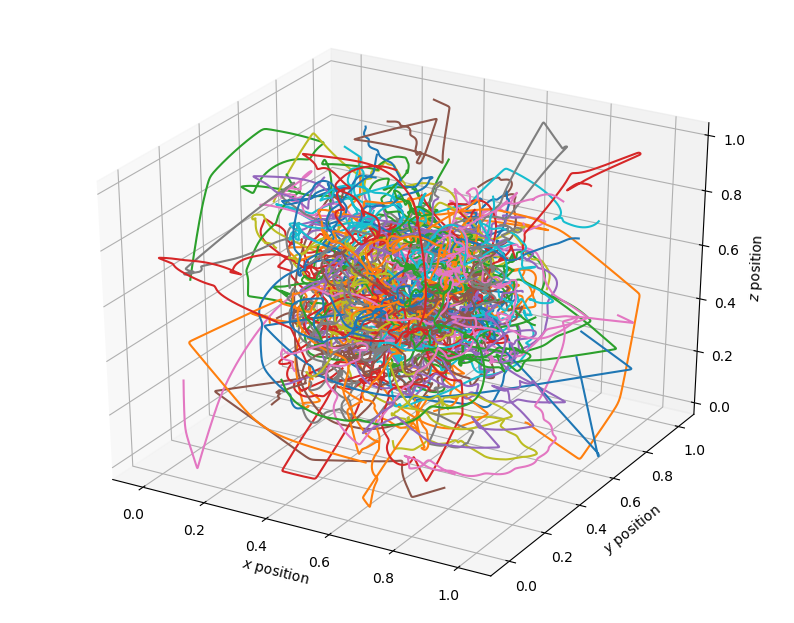

In [16]:
solution.isel(time=range(solution.time.size//10 * 4, solution.time.size // 10 * 10)).particletracker.plot_trajectories()

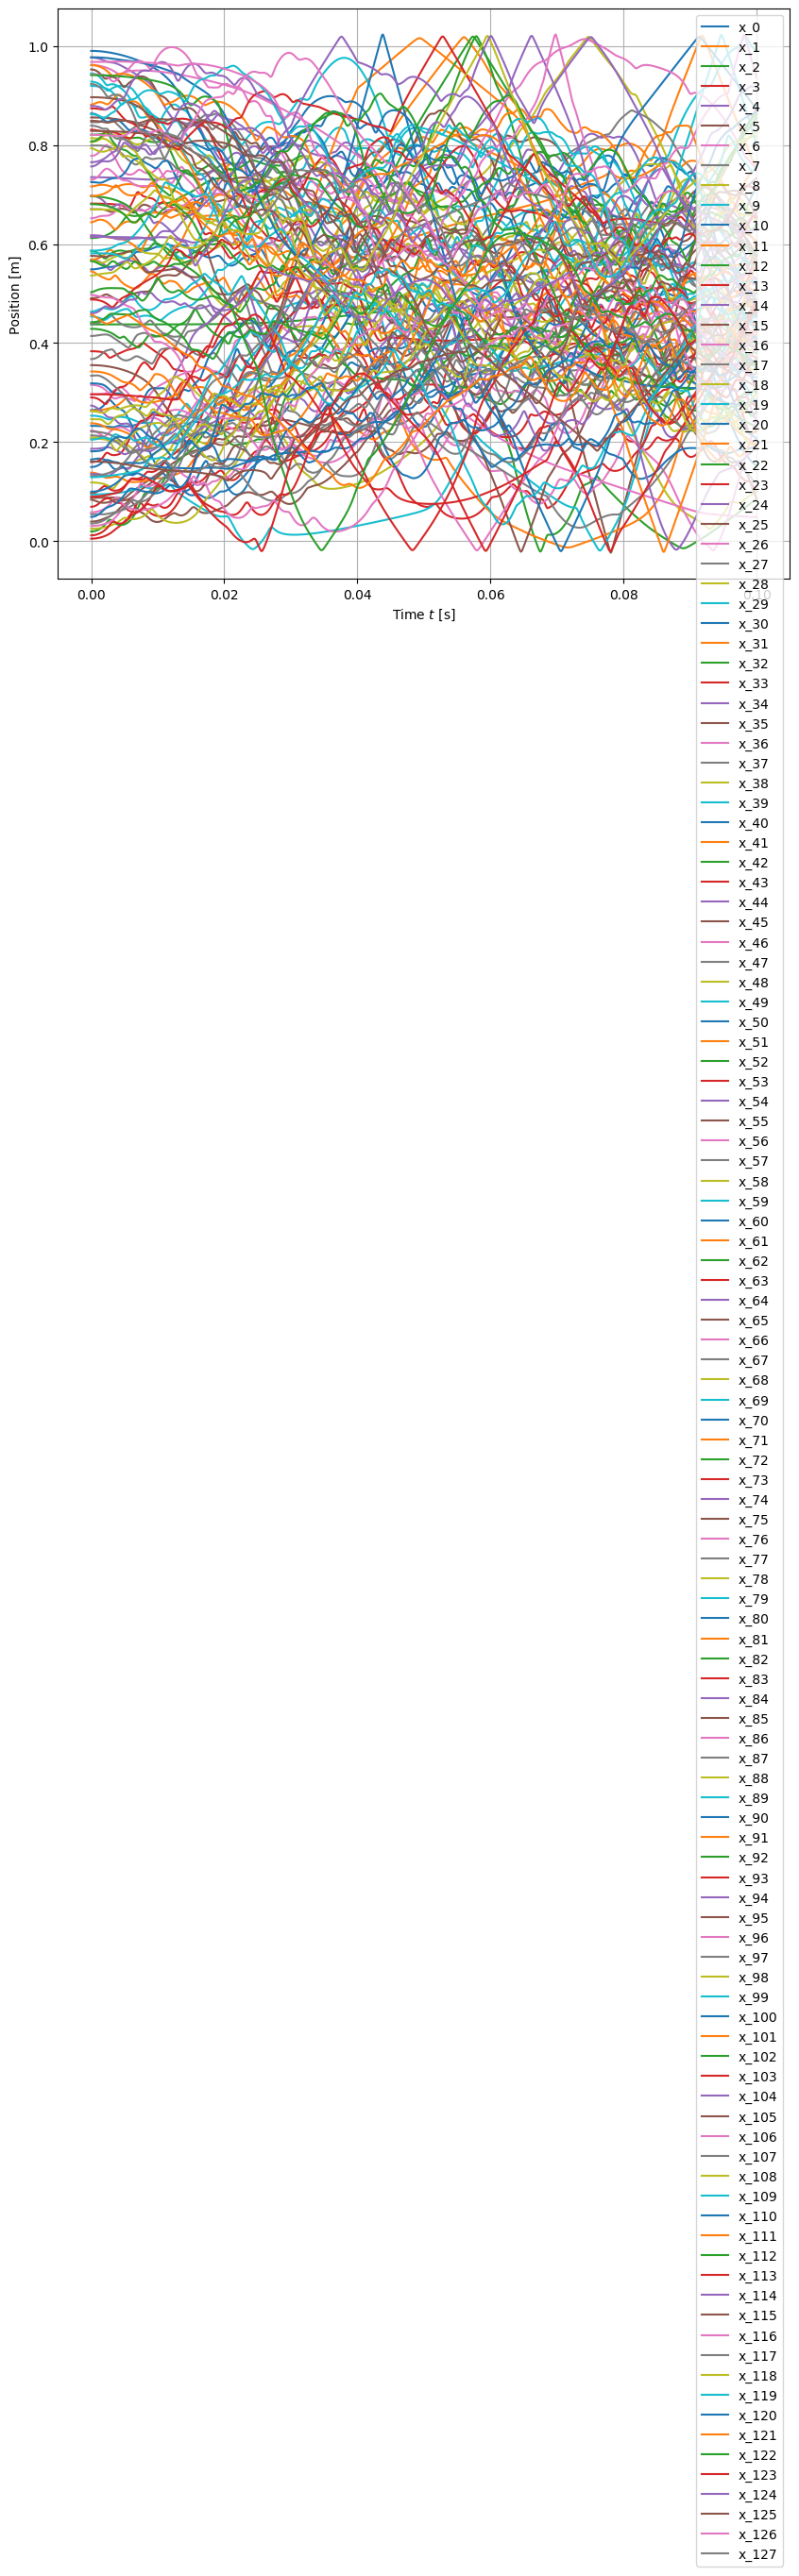

In [17]:
solution.particletracker.plot_time_trajectories('x')

In [18]:
import pyvista
fig = pyvista.PlotterITK()
for particle in range(N):
    solution.particletracker.visualize(fig, particle=particle, stride=10);
fig.add_mesh(pyvista.Cube(bounds=(0, L.si.value, 0, L.si.value, 0, L.si.value)), opacity=0.1)
fig.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [19]:
solution.position.isel(time=500)
fig = pyvista.PlotterITK()
fig.add_mesh(pyvista.Cube(bounds=(0, L.si.value, 0, L.si.value, 0, L.si.value)), opacity=0.1)
points = pyvista.PolyData(solution.position.isel(time=500).values)
points['kinetic'] = solution.kinetic_energy.isel(time=500).values
fig.add_mesh(points, scalars='kinetic', eye_dome_lightning = True)
for particle in range(N):
    solution.isel(time=range(0, 500)).particletracker.visualize(fig, particle=particle)
fig.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

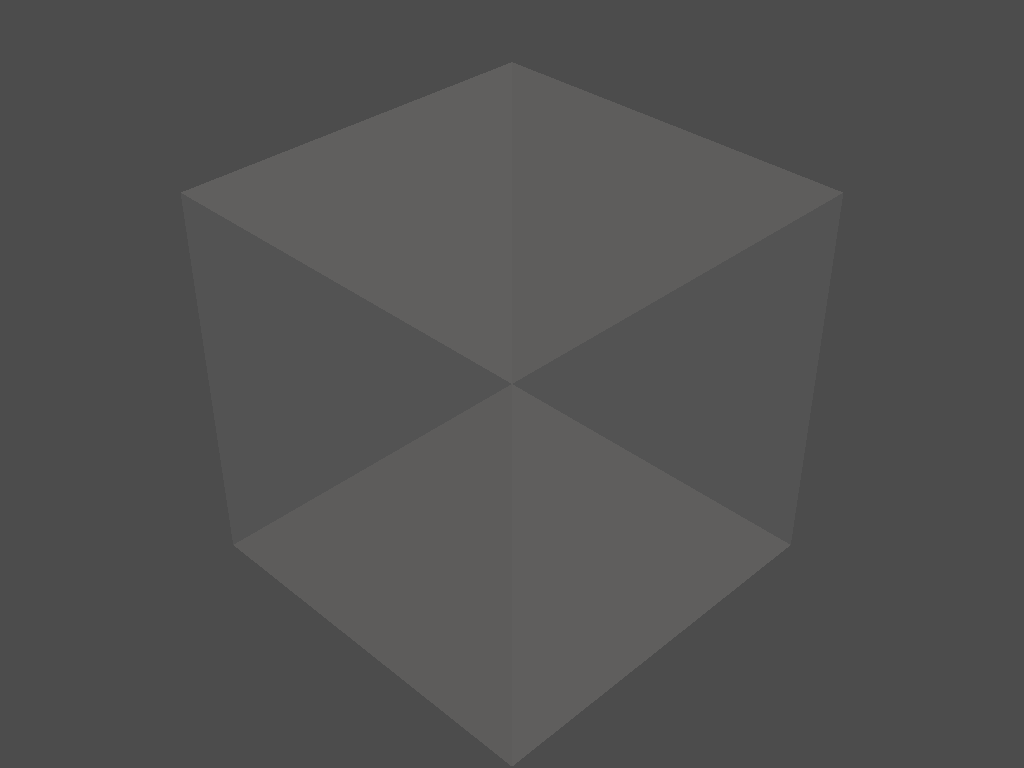

In [20]:
solution.particletracker.animate("nbody.mp4", plasma = forces['njit'], notebook_display = True)

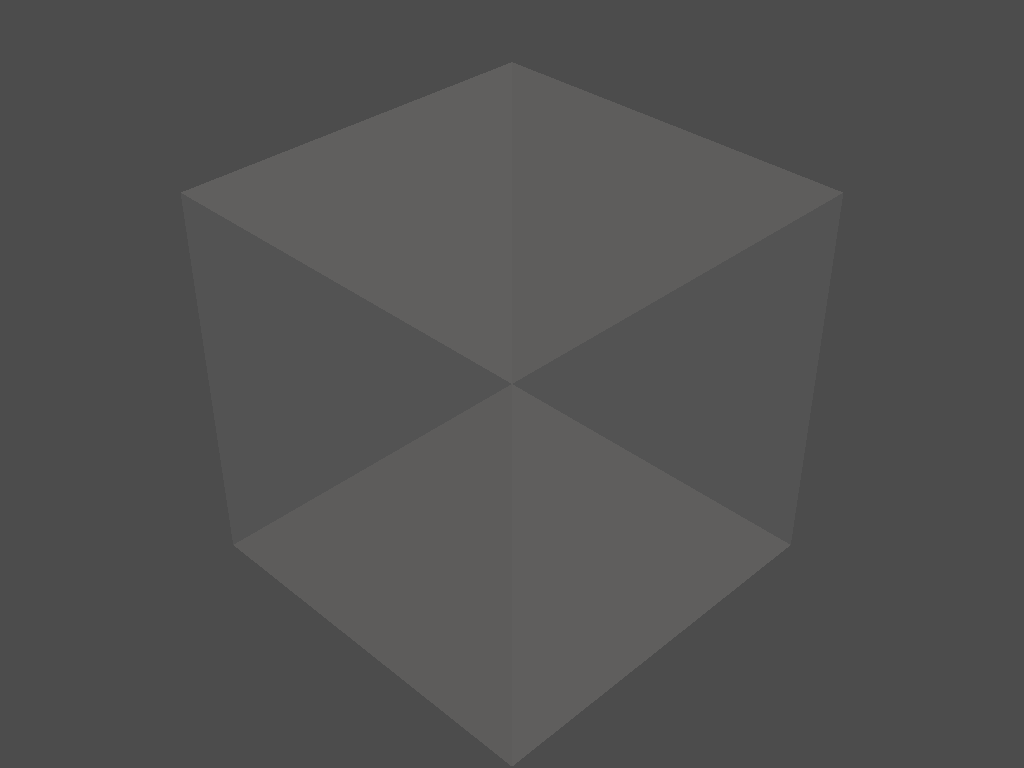

In [21]:
solution.particletracker.animate("/mnt/hdd/nbody2.mp4", solution.particle, nframes=100, notebook_display = True, plasma = forces['njit'])